In [1]:
import os
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
import math

from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor

import pmdarima.arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import pearsonr

In [2]:
df = pd.read_csv('Impute_misvalues_hungyen.csv')
df['Hour'] = df['Hour'].replace('#NUM!', 0)
df['Hour'] = pd.to_datetime(df['Hour'], format='%H', errors='coerce').dt.time
df['Hour'] = df['Hour'].astype(str)


df['DateTime'] = pd.to_datetime(df['Date'] + ' ' + df['Hour'])
df = df.set_index('DateTime')
df.drop(['Date', 'Hour'], axis = 1, inplace = True)

df.head()

,Waterlevel
DateTime,
2008-01-01 00:00:00,47.0
2008-01-01 01:00:00,43.0
2008-01-01 02:00:00,40.0
2008-01-01 03:00:00,37.0
2008-01-01 04:00:00,34.0


In [3]:
train_size = int(len(df) * 0.7)
train, test = df[:train_size].iloc[:, [-1]], df[train_size:].iloc[:, [-1]]

train, test

(                     Waterlevel
 DateTime                       
 2008-01-01 00:00:00        47.0
 2008-01-01 01:00:00        43.0
 2008-01-01 02:00:00        40.0
 2008-01-01 03:00:00        37.0
 2008-01-01 04:00:00        34.0
 ...                         ...
 2013-02-11 05:00:00        86.0
 2013-02-11 06:00:00       100.0
 2013-02-11 07:00:00       115.0
 2013-02-11 08:00:00       128.0
 2013-02-11 09:00:00       134.0
 
 [44842 rows x 1 columns],
                      Waterlevel
 DateTime                       
 2013-02-11 10:00:00       133.0
 2013-02-11 11:00:00       127.0
 2013-02-11 12:00:00       122.0
 2013-02-11 13:00:00       115.0
 2013-02-11 14:00:00       107.0
 ...                         ...
 2015-04-23 00:00:00       127.0
 2015-04-23 01:00:00       124.0
 2015-04-23 02:00:00       120.0
 2015-04-23 03:00:00       115.0
 2015-04-23 04:00:00       109.0
 
 [19219 rows x 1 columns])

In [4]:
scaler = MinMaxScaler()
train['Waterlevel'] = scaler.fit_transform(train)
test['Waterlevel'] = scaler.transform(test)

In [5]:
train_data = train.values
test_data = test.values

In [6]:
timesteps = 164


In [7]:
train_data_timesteps=np.array([[j for j in train_data[i:i+timesteps]] 
                               for i in range(0,len(train_data)-timesteps+1)])[:,:,0]

test_data_timesteps=np.array([[j for j in test_data[i:i+timesteps]] 
                              for i in range(0,len(test_data)-timesteps+1)])[:,:,0]


In [8]:
x_train, y_train = train_data_timesteps[:,:timesteps-1],train_data_timesteps[:,[timesteps-1]]
x_test, y_test = test_data_timesteps[:,:timesteps-1],test_data_timesteps[:,[timesteps-1]]

x_train, y_train

(array([[0.10782866, 0.10192024, 0.09748892, ..., 0.17282127, 0.16395864,
         0.15509601],
        [0.10192024, 0.09748892, 0.09305761, ..., 0.16395864, 0.15509601,
         0.14623338],
        [0.09748892, 0.09305761, 0.08862629, ..., 0.15509601, 0.14623338,
         0.13737075],
        ...,
        [0.1816839 , 0.17725258, 0.17282127, ..., 0.14327917, 0.16543575,
         0.18611521],
        [0.17725258, 0.17282127, 0.16838996, ..., 0.16543575, 0.18611521,
         0.20827179],
        [0.17282127, 0.16838996, 0.16395864, ..., 0.18611521, 0.20827179,
         0.22747415]]),
 array([[0.14623338],
        [0.13737075],
        [0.12998523],
        ...,
        [0.20827179],
        [0.22747415],
        [0.23633678]]))

In [9]:
def calculate_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    
    r, _ = pearsonr(y_true, y_pred)
    
    T = len(y_true)
    max_x = max(y_true)
    min_x = min(y_true)
    
    sim_sum = 0
    for i in range(T):
        sim_sum += 1 / (1 + abs(y_pred[i] - y_true[i]) / (max_x - min_x))
    sim = sim_sum / T
    
    sd_y = np.std(y_pred)
    sd_x = np.std(y_test)
    fsd = 2 * np.abs(sd_y - sd_x) / (sd_y + sd_x)
    
    nse = 1 - (np.sum((y_pred - y_true) ** 2) / np.sum((y_true - np.mean(y_true)) ** 2))
    
    return {
        'MAE': mae,
        'RMSE': rmse,
        'R': r,
        'SIM': sim,
        'FSD': fsd,
        'NSE': nse
    }

# SVR (Linear)

In [10]:
model_SVR = SVR(kernel='linear',gamma=0.01, C=50, epsilon = 0.005)
model_SVR.fit(x_train, y_train[:,0])

SVR(C=50, epsilon=0.005, gamma=0.01, kernel='linear')

In [11]:
predictions_linear_svm = model_SVR.predict(x_train)
predictions_linear_svm 

array([0.14699598, 0.13766778, 0.1299266 , ..., 0.20309888, 0.22538802,
       0.2394349 ])

In [12]:
predictions_linear_svm.shape

(44679,)

In [13]:
train_data

array([[0.10782866],
       [0.10192024],
       [0.09748892],
       ...,
       [0.20827179],
       [0.22747415],
       [0.23633678]])

In [17]:
res_train = train_data.flatten()[timesteps-1:] - predictions_linear_svm

In [38]:
res_train.shape

(44679,)

In [18]:
hours = 120
def forecast_value (model, hours):
    current_window = x_train[-1,:].tolist()

    predict = []

    for _ in range(hours):
        next_value = model.predict([current_window])[0]
        predict.append(next_value)
        
        current_window.pop(0)  
        current_window.append(next_value)
    predict_array = np.array(predict).reshape(-1, 1)
    return(predict_array)
forecast_linear_SVR = forecast_value(model_SVR, hours)    

In [19]:
forecast_linear_SVR

array([[0.2394349 ],
       [0.24239823],
       [0.23676616],
       [0.2279206 ],
       [0.21818663],
       [0.20880835],
       [0.1982333 ],
       [0.18683772],
       [0.17533611],
       [0.16375545],
       [0.15258486],
       [0.14082115],
       [0.13034306],
       [0.12161459],
       [0.11464728],
       [0.10714252],
       [0.09927799],
       [0.09442438],
       [0.09852427],
       [0.11305408],
       [0.13385713],
       [0.15590244],
       [0.17701063],
       [0.19725358],
       [0.21480576],
       [0.22562276],
       [0.22808301],
       [0.22370104],
       [0.21564541],
       [0.20773858],
       [0.20041089],
       [0.19278342],
       [0.18358004],
       [0.17455391],
       [0.1653148 ],
       [0.15532619],
       [0.1450414 ],
       [0.13582803],
       [0.1280866 ],
       [0.12107602],
       [0.11384448],
       [0.10650978],
       [0.10352445],
       [0.10797018],
       [0.12065324],
       [0.13855231],
       [0.15728863],
       [0.175

In [29]:
res_test = test_data.flatten()[:120] - forecast_linear_SVR.flatten()

In [30]:
res_test

array([-0.00457523, -0.01640119, -0.01815464, -0.01964881, -0.02173168,
       -0.02417024, -0.02541203, -0.02731039, -0.02762563, -0.02933891,
       -0.03146226, -0.03151539, -0.03285414, -0.03594251, -0.03931493,
       -0.0421499 , -0.03133116, -0.00727519,  0.00930438,  0.01397694,
        0.01089915,  0.0065791 , -0.00123515, -0.00966126, -0.01835081,
       -0.02178229, -0.02424254, -0.02429188, -0.02214467, -0.02014626,
       -0.0216812 , -0.02587057, -0.02848402, -0.03275184, -0.03532958,
       -0.03568069, -0.03868985, -0.04129332, -0.04536873, -0.05017499,
       -0.05328318, -0.053334  , -0.04296315, -0.02229809, -0.01430169,
       -0.0144755 , -0.02139498, -0.02772866, -0.03279056, -0.03904351,
       -0.0427205 , -0.04273023, -0.03848984, -0.0350315 , -0.03355535,
       -0.03308789, -0.03462091, -0.03637206, -0.03924359, -0.04187041,
       -0.04609215, -0.04855824, -0.05169793, -0.05579293, -0.06009383,
       -0.06252051, -0.05132774, -0.02728739, -0.01311591, -0.01

In [32]:
res = scaler.inverse_transform(res_test.reshape(-1,1)) 

In [46]:
res

array([[-29.09742779],
       [-37.10360318],
       [-38.29069343],
       [-39.30224425],
       [-40.71234717],
       [-42.36325302],
       [-43.20394616],
       [-44.48913406],
       [-44.70254912],
       [-45.86244192],
       [-47.29994744],
       [-47.33592027],
       [-48.24225103],
       [-50.33307703],
       [-52.6162097 ],
       [-54.53548479],
       [-47.21119725],
       [-30.92530203],
       [-19.70093354],
       [-16.53760928],
       [-18.6212788 ],
       [-21.54594874],
       [-26.83619588],
       [-32.54067549],
       [-38.42349622],
       [-40.74661151],
       [-42.4121988 ],
       [-42.44560462],
       [-40.99194026],
       [-39.63901679],
       [-40.67817117],
       [-43.51437713],
       [-45.2836849 ],
       [-48.17299725],
       [-49.9181225 ],
       [-50.15582812],
       [-52.19302979],
       [-53.95557478],
       [-56.71462763],
       [-59.96846774],
       [-62.07271423],
       [-62.10711839],
       [-55.08605289],
       [-41

In [44]:
train_res=np.array([[j for j in res_train.reshape(-1,1)[i:i+timesteps]] 
                               for i in range(0,len(res_train)-timesteps+1)])[:,:,0]

# test_res=np.array([[j for j in res_test.reshape(-1,1)[i:i+timesteps]] 
#                               for i in range(0,len(res_test)-timesteps+1)])[:,:,0]

In [45]:
x_train, y_train = train_res[:,:timesteps-1],train_res[:,[timesteps-1]]
# x_test, y_test = test_res[:,:timesteps-1],test_res[:,[timesteps-1]]

x_train, y_train

(array([[-7.62599802e-04, -2.97027923e-04,  5.86328846e-05, ...,
         -1.30192231e-03, -1.75434742e-03, -8.11950534e-04],
        [-2.97027923e-04,  5.86328846e-05, -1.13109109e-03, ...,
         -1.75434742e-03, -8.11950534e-04,  6.48173188e-04],
        [ 5.86328846e-05, -1.13109109e-03, -2.10926223e-03, ...,
         -8.11950534e-04,  6.48173188e-04, -1.34863152e-03],
        ...,
        [ 6.46309174e-04,  7.96413600e-04,  5.67367004e-04, ...,
          2.43472370e-04, -2.87087492e-03,  2.77876544e-04],
        [ 7.96413600e-04,  5.67367004e-04, -9.54052440e-04, ...,
         -2.87087492e-03,  2.77876544e-04,  5.17290312e-03],
        [ 5.67367004e-04, -9.54052440e-04, -1.00808710e-03, ...,
          2.77876544e-04,  5.17290312e-03,  2.08613188e-03]]),
 array([[ 6.48173188e-04],
        [-1.34863152e-03],
        [-2.29156523e-05],
        ...,
        [ 5.17290312e-03],
        [ 2.08613188e-03],
        [-3.09812081e-03]]))

In [47]:
def calculate_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    
    r, _ = pearsonr(y_true, y_pred)
    
    T = len(y_true)
    max_x = max(y_true)
    min_x = min(y_true)
    
    sim_sum = 0
    for i in range(T):
        sim_sum += 1 / (1 + abs(y_pred[i] - y_true[i]) / (max_x - min_x))
    sim = sim_sum / T
    
    sd_y = np.std(y_pred)
    sd_x = np.std(y_test)
    fsd = 2 * np.abs(sd_y - sd_x) / (sd_y + sd_x)
    
    nse = 1 - (np.sum((y_pred - y_true) ** 2) / np.sum((y_true - np.mean(y_true)) ** 2))
    
    return {
        'MAE': mae,
        'RMSE': rmse,
        'R': r,
        'SIM': sim,
        'FSD': fsd,
        'NSE': nse
    }

# KNN

In [48]:
knn_regressor = KNeighborsRegressor(n_neighbors=5)
knn_regressor.fit(x_train, y_train[:,0])

KNeighborsRegressor()

In [49]:
predict_KNN = forecast_value(knn_regressor, hours)

In [50]:
predict_KNN = scaler.inverse_transform(predict_KNN)

In [51]:
predict_KNN

array([[-25.94725485],
       [-26.4985611 ],
       [-26.10700789],
       [-25.69452429],
       [-25.8436461 ],
       [-25.91614938],
       [-26.31818926],
       [-26.23796432],
       [-26.59623467],
       [-25.93498871],
       [-26.50882312],
       [-25.62426886],
       [-26.26962299],
       [-26.84709605],
       [-25.88491342],
       [-26.16487699],
       [-26.07066788],
       [-25.94335341],
       [-26.21143791],
       [-26.15066859],
       [-26.36623535],
       [-25.94921358],
       [-25.66551064],
       [-25.49185251],
       [-26.52718216],
       [-25.66365472],
       [-26.1949711 ],
       [-26.02023963],
       [-26.53290474],
       [-26.39811285],
       [-26.09289452],
       [-26.49726519],
       [-25.93426621],
       [-25.46243864],
       [-26.06457375],
       [-25.83239538],
       [-26.41233311],
       [-26.3961247 ],
       [-25.76336882],
       [-26.14844342],
       [-26.10510919],
       [-26.75093298],
       [-26.43974987],
       [-24

In [61]:
predict_SVR_KNN = scaler.inverse_transform(forecast_linear_SVR).flatten()[:120] + predict_KNN.flatten()
predict_SVR_KNN

array([110.15017294, 111.60504208, 108.18368554, 102.60771996,
        95.86870107,  89.44710365,  81.8857569 ,  74.25116974,
        66.10631445,  58.92745321,  50.79112433,  43.71165142,
        35.97262803,  29.48598098,  25.73129628,  20.3706078 ,
        15.14052937,  11.98194862,  14.48949563,  24.38694068,
        38.25504344,  53.59673517,  68.17068523,  82.04882298,
        92.89631406, 101.08295679, 102.21722769,  99.425365  ,
        93.45903552,  88.24090393,  83.58527665,  78.01711194,
        72.34941869,  66.71055861,  59.85354875,  53.32343274,
        45.78069668,  39.55945008,  34.95125881,  29.82002432,
        24.96760504,  19.35618541,  17.64630302,  22.58705971,
        29.75312343,  41.63936822,  54.94911245,  66.23161327,
        78.51113474,  87.67515998,  93.2362006 ,  93.46550911,
        90.47092209,  83.31910487,  78.44415364,  73.19645126,
        70.14312147,  66.10271254,  62.98451844,  58.46833643,
        53.58097711,  48.56427736,  42.58038432,  38.52

In [54]:
y_test_original = scaler.inverse_transform(test)

In [80]:
metrics_SVR_KNN = calculate_metrics(y_test_original[:hours].flatten(), predict_SVR_KNN[:hours].flatten())
for metric, value in metrics_SVR_KNN.items():
    print(f'{metric}: {value}')

MAE: 12.385460030152196
RMSE: 16.145611258516126
R: 0.8341731898186651
SIM: 0.9135036308914325
FSD: 1.981648245435818
NSE: 0.6901667528572007


# SVR

In [57]:
model_SVR_rbf = SVR(kernel='rbf',gamma=0.01, C=50, epsilon = 0.005)
model_SVR_rbf.fit(x_train, y_train[:,0])

SVR(C=50, epsilon=0.005, gamma=0.01)

In [58]:
predict_SVR_rbf = forecast_value(model_SVR_rbf, hours)

In [59]:
predict_SVR_rbf = scaler.inverse_transform(predict_SVR_rbf)

In [63]:
predict_SVR_SVR_rbf = scaler.inverse_transform(forecast_linear_SVR).flatten()[:120] + predict_SVR_rbf.flatten()
predict_SVR_SVR_rbf

array([110.17344912, 112.38925316, 108.12916585, 102.51263496,
        95.53320682,  89.56807674,  82.51247248,  74.90377192,
        67.17540875,  59.3217881 ,  51.71793342,  43.98840278,
        36.71228259,  30.25780153,  25.55688012,  20.79036805,
        15.60870575,  11.92865728,  14.23327555,  24.35091376,
        38.59812533,  52.67656309,  67.37133003,  81.03364844,
        93.18998649, 101.3951433 , 102.85927265,  99.67742178,
        93.7713544 ,  88.73634742,  84.06672284,  78.84864042,
        72.27999409,  66.22490924,  59.66922628,  53.42686489,
        46.83129446,  39.53218783,  34.6863128 ,  30.20722846,
        25.70671547,  20.42008611,  18.26439076,  21.2241121 ,
        29.74217779,  41.35648337,  54.35453955,  66.67819248,
        78.2387448 ,  87.44221438,  93.06354804,  93.13597551,
        89.41155149,  83.64619336,  78.97052771,  75.05312151,
        70.31782681,  66.70145308,  62.25712218,  58.22697803,
        53.40917947,  47.60781771,  42.61258405,  38.44

In [79]:
metrics_SVR_SVR = calculate_metrics(y_test_original[:hours].flatten(), predict_SVR_SVR_rbf[:hours].flatten())
for metric, value in metrics_SVR_SVR.items():
    print(f'{metric}: {value}')

MAE: 12.265888794155577
RMSE: 16.0822138752701
R: 0.8357961578796208
SIM: 0.9143660964874721
FSD: 1.9816539447752772
NSE: 0.6925951592434989


In [66]:
x_train = scaler.inverse_transform(x_train)
y_train = scaler.inverse_transform(y_train)

In [68]:
model_RF = RandomForestRegressor(n_estimators=300, max_features=4, random_state=42)

model_RF.fit(x_train, y_train[:,0])

RandomForestRegressor(max_features=4, n_estimators=300, random_state=42)

In [69]:
predict_RF = forecast_value(model_RF, hours) 

In [75]:
predict_SVR_RF = scaler.inverse_transform(forecast_linear_SVR).flatten()[:120] + predict_RF.flatten()
predict_SVR_RF

array([108.78240685, 112.24048749, 108.37832591, 102.2644779 ,
        95.75598998,  89.29338619,  82.13307883,  74.32547664,
        66.68014546,  58.90151757,  51.35027185,  43.64010278,
        36.32717356,  30.30750731,  25.66995324,  20.53401133,
        15.24777609,  12.16856172,  14.6053512 ,  24.65436804,
        38.80985535,  53.37207782,  67.83905522,  81.38553272,
        93.23416323, 100.80896081, 102.51725652,  99.4034652 ,
        94.13297296,  88.60168488,  83.5330144 ,  78.43236603,
        72.35150725,  66.08630086,  59.91017522,  53.15022909,
        46.26343556,  39.93759328,  34.68292756,  29.95608427,
        25.15404002,  20.15996169,  18.16144605,  21.13121961,
        29.7385527 ,  41.78183325,  54.56819624,  66.91801906,
        78.39241885,  87.4153863 ,  92.83488365,  93.19683915,
        89.15358758,  83.85652875,  78.69246496,  74.3302436 ,
        70.32640939,  66.70788265,  62.47429655,  58.31881809,
        53.04560651,  47.78452366,  43.03300946,  38.70

In [76]:
time_forecast = [3,  6, 12, 24, 36, 72, 120]
for hours in time_forecast:
    metrics_SVR_RF = calculate_metrics(y_test_original[:hours].flatten(), predict_SVR_RF[:hours].flatten())
    for metric, value in metrics_SVR_RF.items():
        print(f'forecast {hours} hours {metric}: {value}')

MAE: 12.269239618555009
RMSE: 16.040805461966258
R: 0.8366391518347349
SIM: 0.9142809757239819
FSD: 1.981609344166834
NSE: 0.6941761305352474


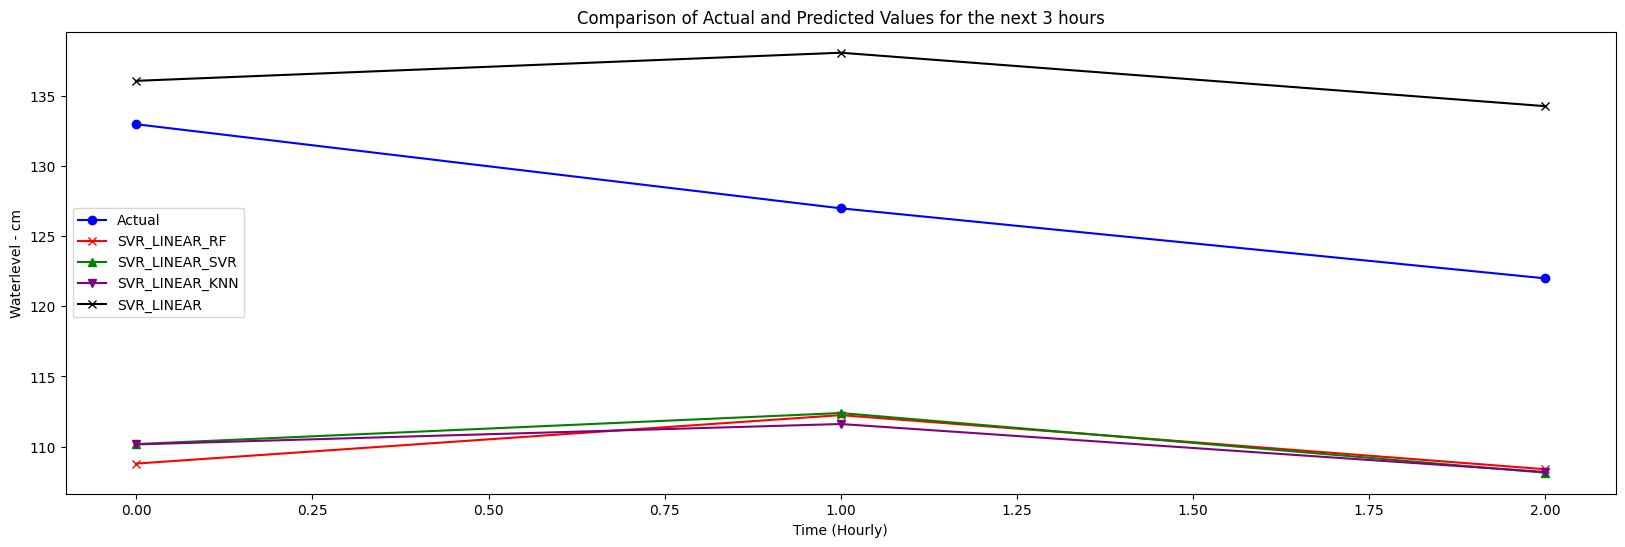

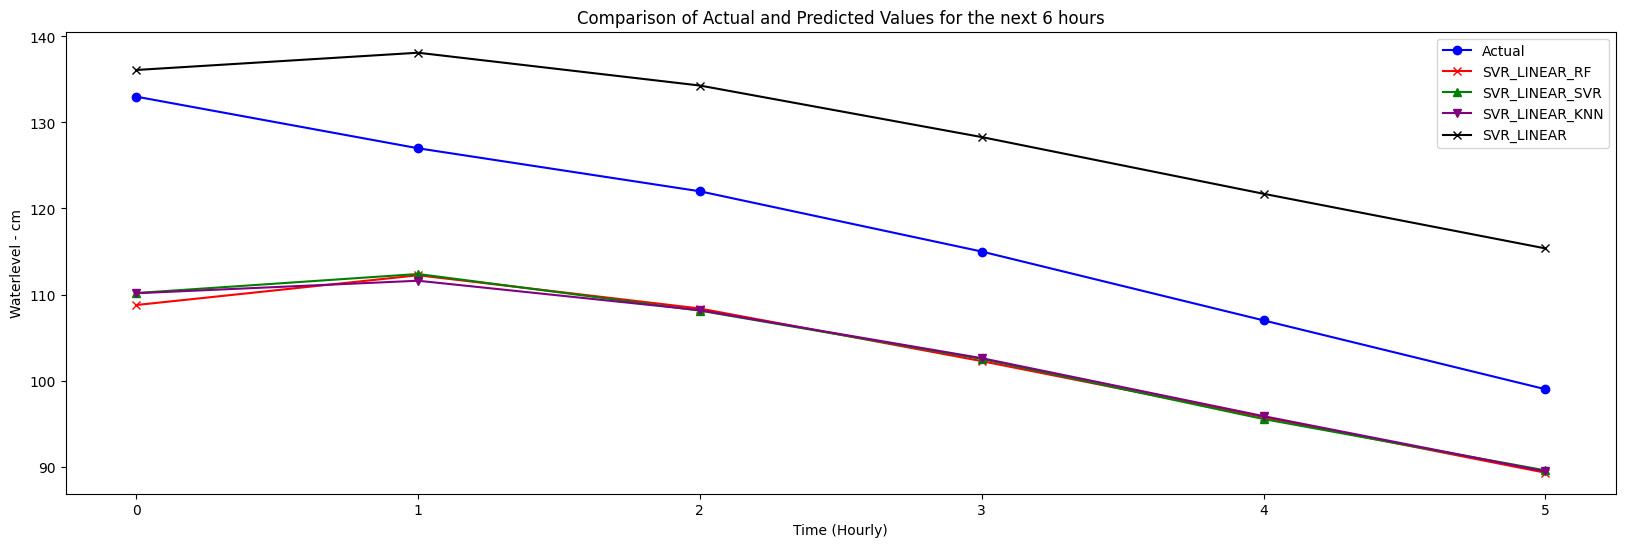

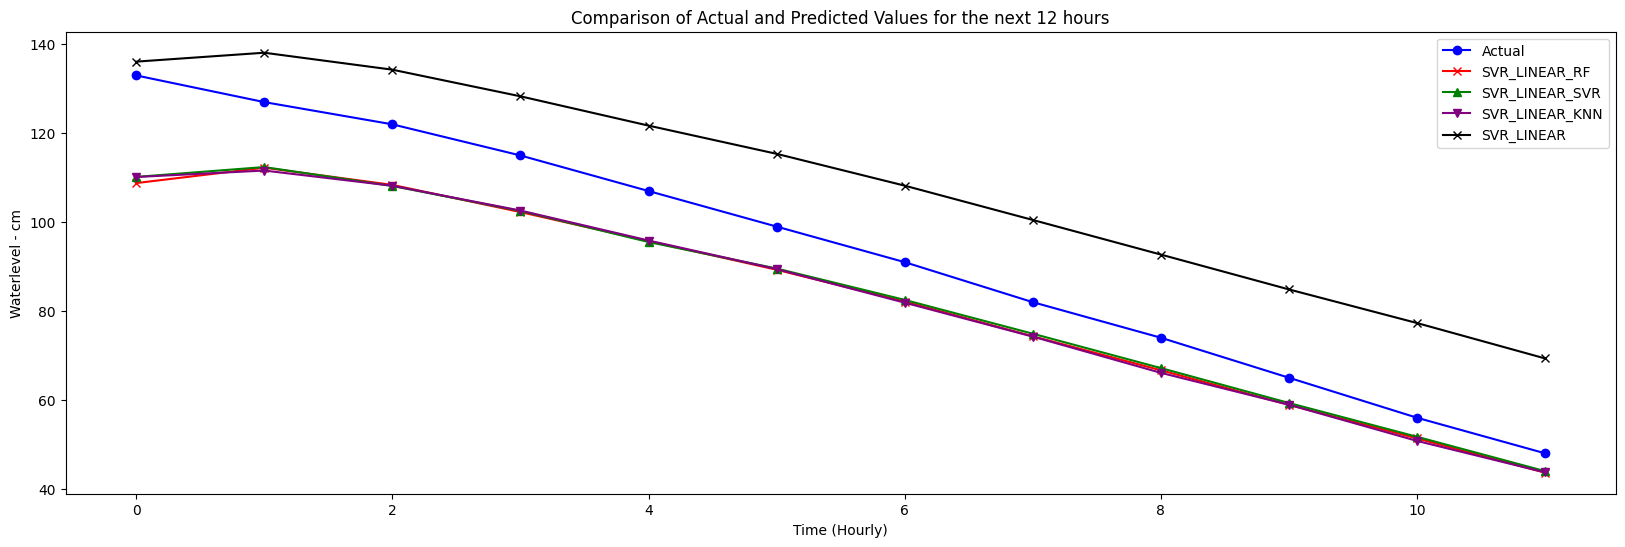

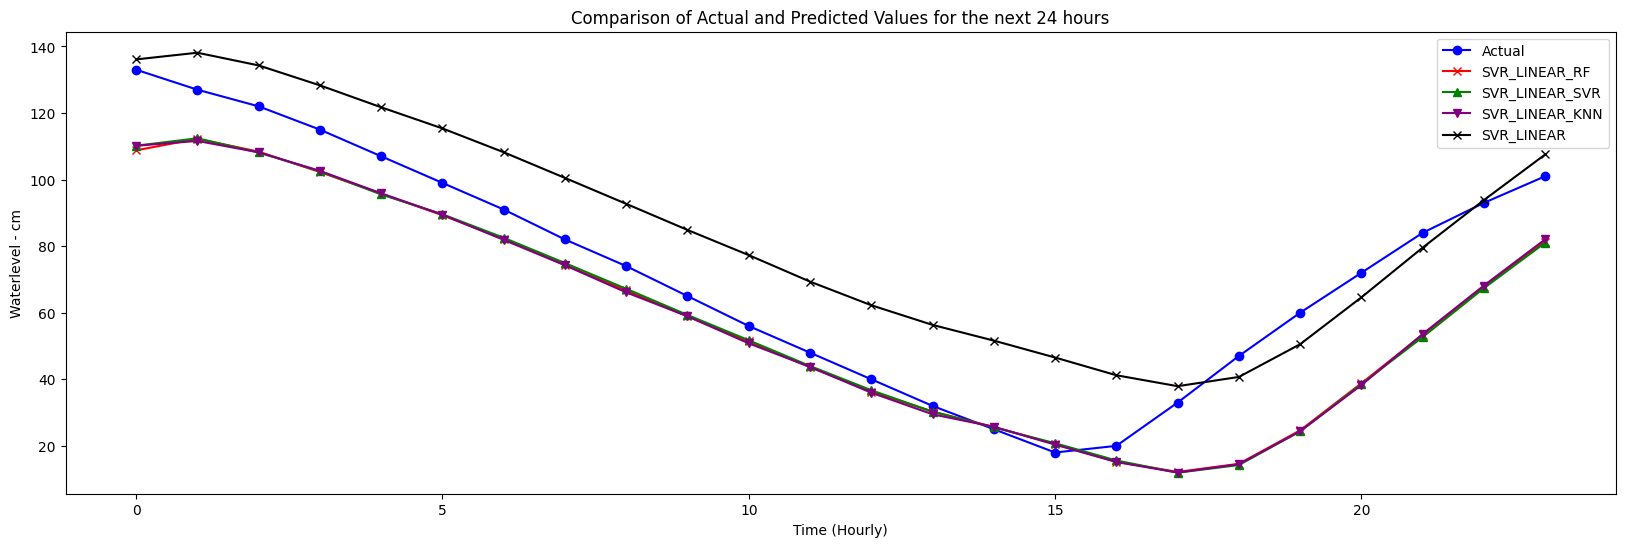

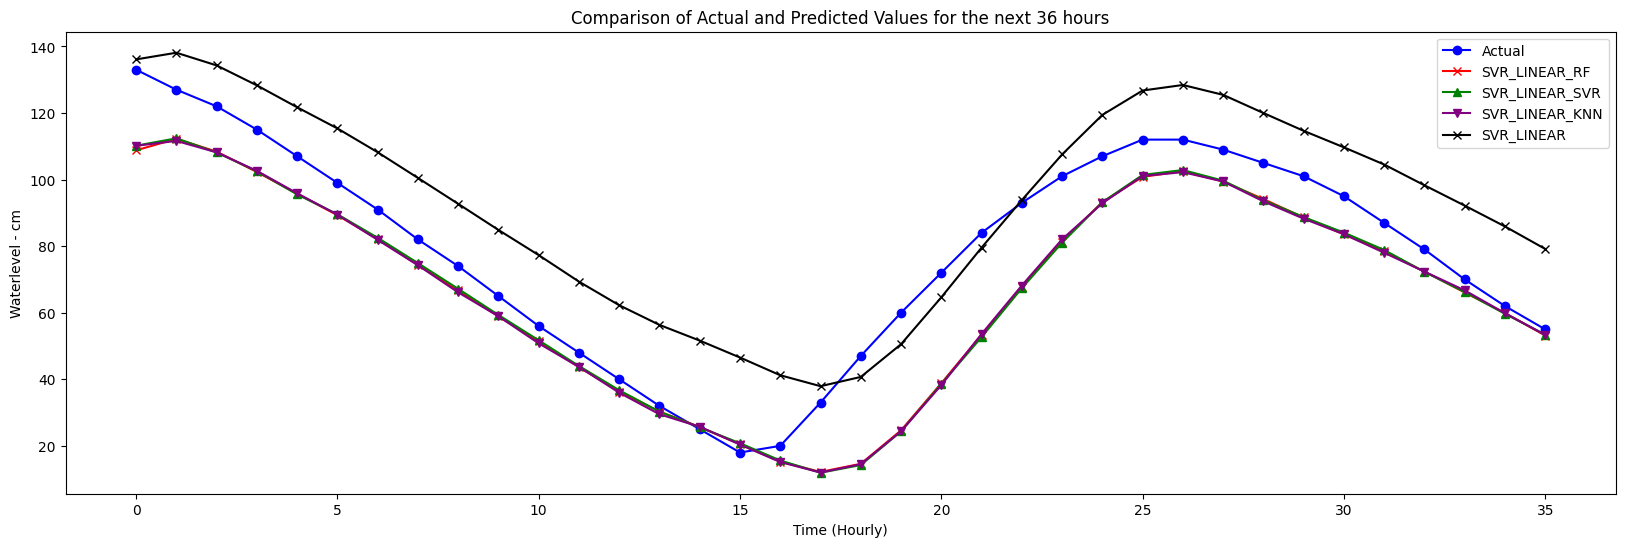

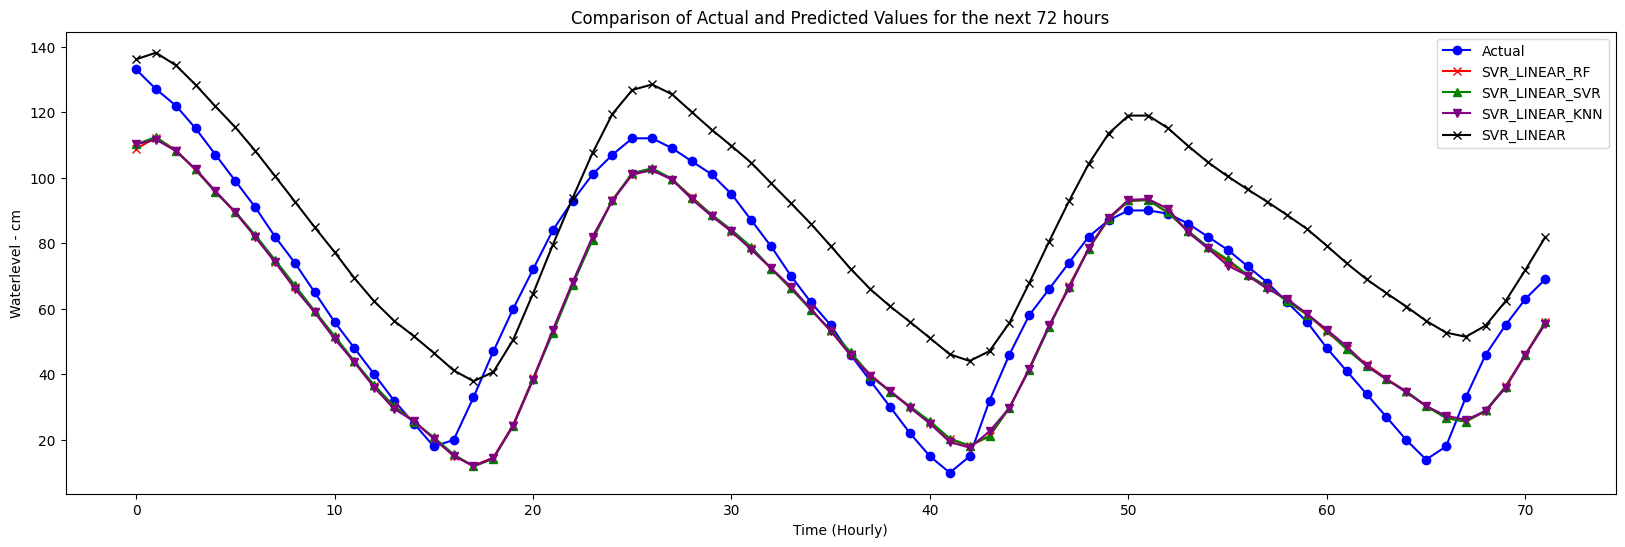

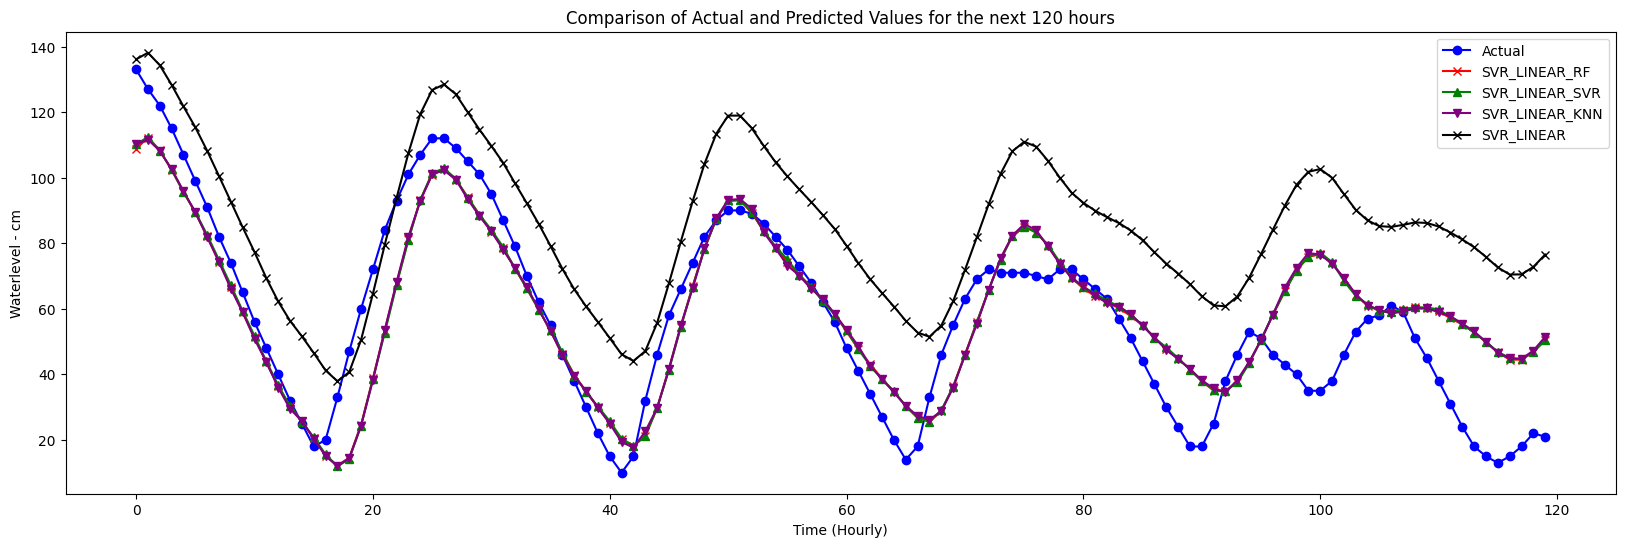

In [78]:
time_forecast = [3,  6, 12, 24, 36, 72, 120]
for hours in time_forecast:
    plt.figure(figsize=(20, 6))
    
    plt.plot(y_test_original.flatten()[:hours], label='Actual', color='blue', marker='o')
    plt.plot(predict_SVR_RF.flatten()[:hours], label='SVR_LINEAR_RF', color='red', marker='x')
    plt.plot(predict_SVR_SVR_rbf.flatten()[:hours], label='SVR_LINEAR_SVR', color='green', marker='^')
    plt.plot(predict_SVR_KNN.flatten()[:hours], label='SVR_LINEAR_KNN', color='purple', marker='v')
    plt.plot(scaler.inverse_transform(forecast_linear_SVR)[:hours], label='SVR_LINEAR', color='black', marker='x')
    
    plt.title(f'Comparison of Actual and Predicted Values for the next {hours} hours')
    plt.xlabel('Time (Hourly)')
    plt.ylabel('Waterlevel - cm')
    plt.legend()

    plt.show()